In [ ]:
import torch
from src.utils.idealscore import *
from src.utils.data import *

In [2]:
dataset, metadata = get_dataset('cifar10')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Files already downloaded and verified


In [3]:
# scales for each time step. ordered from earliest (low noise) to latest (high noise)
# scales calibrated based on ResNet data

# subsample the dataset to 10k examples out of original 50k; decrease for speed, increase for accuracy
max_samples = 10000

backbone = LocalEquivBordersScoreModule(dataset,
                            image_size=32,
                            channels=3,
                            schedule=cosine_noise_schedule,
                            max_samples=max_samples,
                            shuffle=False)

scales = torch.load('./files/scales_CIFAR10_ResNet_zeros_conditional.pt')

machine = ScheduledScoreMachine(backbone,
                                image_size=32,
                                in_channels=3,
                                noise_schedule=cosine_noise_schedule,
                                score_backbone=True,
                                scales=scales)

In [4]:
model = torch.load('./files/backbone_CIFAR10_ResNet_zeros_conditional.pt', map_location=device)
model.eval()

DDIM(
  (backbone): MinimalResNet(
    (embedding): EmbeddingModule(
      (class_embeddings): Embedding(10, 256)
    )
    (up_projection): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (embs): ModuleList(
      (0-6): 7 x Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): GroupNorm(8, 256, eps=1e-05, affine=True)
        (2): ReLU()
      )
    )
    (convs): ModuleList(
      (0-5): 6 x Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): ReLU()
      )
    )
    (down_projection): Conv2d(256, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
)

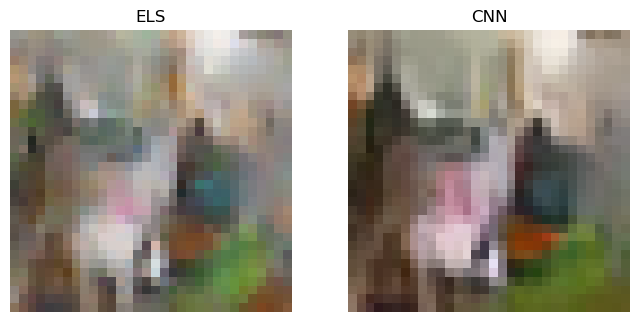

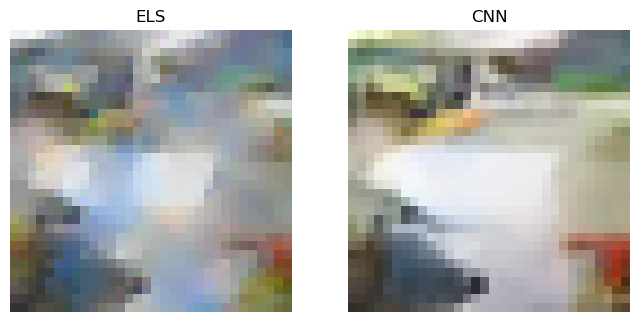

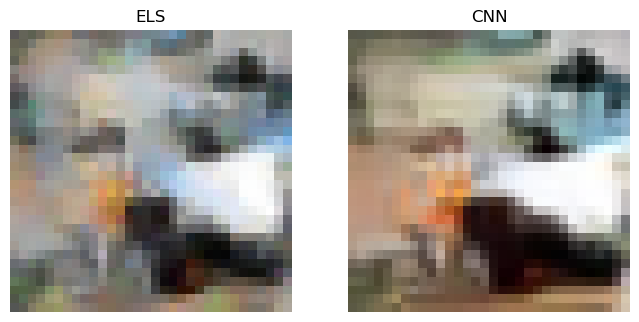

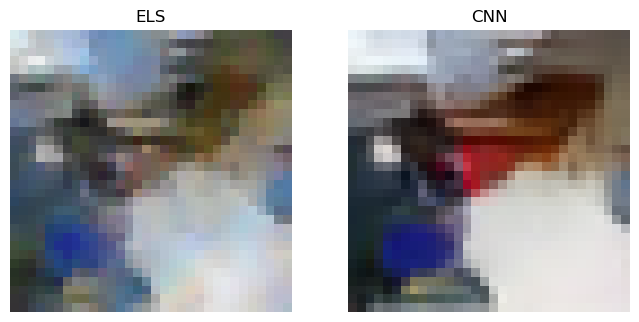

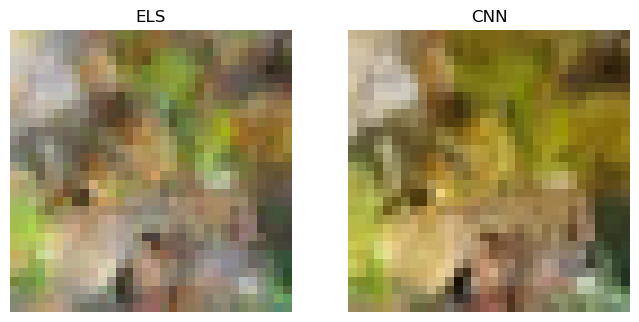

In [8]:
for i in range(5):
    seed = torch.randn(1,3,32,32).to(device)
    label = torch.tensor([np.random.randint(10)]).to(device)

    img_els = machine(seed.clone(), label=label)
    img_model = model.sample(x=seed.clone(), label=label, nsteps=150).clamp(-1,1)

    els_numpy = denormalize(img_els.squeeze().detach().cpu(), metadata['mean'], metadata['std']).numpy().transpose(1,2,0)
    model_numpy = denormalize(img_model.squeeze().detach().cpu(), metadata['mean'], metadata['std']).numpy().transpose(1,2,0)

    fig, ax = plt.subplots(1,2, figsize=(8,4))
    ax[0].imshow(els_numpy)
    ax[0].set_title('ELS')
    ax[0].axis('off')

    ax[1].imshow(model_numpy)
    ax[1].set_title('CNN')
    ax[1].axis('off')

    plt.show()
